# Using Microsoft AI to Build a Lung-Disease Prediction Model Using Chest X-Ray Images - Tutorial 2 - Training from Scratch

## Introduction 

This Jupyter Notebook is the tutorial to walk people through how to build a lung-dissease prediction model using Chest X-ray Images. The full code is in this github repo (https://github.com/Azure/AzureChestXRay) and the blogpost is here (https://blogs.technet.microsoft.com/machinelearning/2018/03/07/using-microsoft-ai-to-build-a-lung-disease-prediction-model-using-chest-x-ray-images/)

This tutorial consists of a few parts:
- Build a lung disease prediction model
- Validate model and get metrics
- Visulaizing the model result

Here are all the resources that are used in this 
- _Dataset_

  - National Institutes of Health ( [NIH](https://www.nih.gov/)) chest x-ray dataset. This dataset is a  [publicly](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)  [available](https://nihcc.app.box.com/v/ChestXray-NIHCC) and medically  [curated](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) dataset.

- _Technique_

  - State-of-the art  [DenseNet](https://arxiv.org/pdf/1608.06993.pdf) for image classification. DenseNet is an open-source deep learning algorithm with implementations available in  [Keras](https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/densenet.py) (using  [TensorFlow](https://www.tensorflow.org/) as a back-end). We also explored the  [PyTorch](http://pytorch.org/) version of DenseNet.

  - [Class Activation Maps](http://cnnlocalization.csail.mit.edu/) are used to understand model activation and visualize it.

- _Tools and Platforms_

  - [Deep Learning VMs with GPU acceleration](https://docs.microsoft.com/en-us/azure/machine-learning/data-science-virtual-machine/deep-learning-dsvm-overview) are used as the compute environment.

  - [Azure Machine Learning](https://azure.microsoft.com/en-us/services/machine-learning-services/) is used as a managed machine learning service for project management, run history and version control, and model deployment.


The  [source code we provide on GitHub](https://github.com/Azure/AzureChestXRay) allows you to build the x-ray image pathology classification system in less than an hour using the model pretrained on ChestX-ray14 data. If needed, one can also recreate and expand the full multi-GPU training pipeline starting with a model pretrained using the  [ImageNet](http://image-net.org/) dataset.

The source code, tools, and discussion below are provided to assist data scientists in understanding the potential for developing deep learning -driven intelligent applications using Azure AI services and are intended for research and development use only. The x-ray image pathology classification system is not intended for use in clinical diagnosis or clinical decision-making or for any other clinical use. The performance of this model for clinical use has not been established.

# Downloading packages & create folders
We will install a few packages that will be required later on. We will also download a small portion of data (1% of the original dataset) for tutorial purpose.

In [1]:
import os
import re
import timeit

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import cv2
import keras
import tensorflow as tf
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto(inter_op_parallelism_threads=2, intra_op_parallelism_threads=2)
set_session(tf.Session(config=config))

import keras.backend as K
import numpy as np
import pandas as pd
import tqdm
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import Sequence
from keras_contrib.applications.densenet import DenseNetImageNet121
from tensorflow.python.client import device_lib
import onnxmltools
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras version: 2.2.0
TensorFlow version: 1.8.0


In [2]:

import getpass
username = getpass.getuser()
data_path = "/usr/local/share/xraytutorial"
output_path = os.path.join("/mnt","xraytutorial", username)
print("root folder for all the output would be", output_path, ", input would be", data_path)
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True) 
pathlib.Path(output_path).mkdir(parents=True, exist_ok=True) 


images_path = os.path.join(data_path, 'images.zip')
images_extracted_path = os.path.join(data_path, 'images')
pre_trained_model_path = os.path.join(data_path, 'chexray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5')
label_path = os.path.join(data_path, 'Data_Entry_2017.csv')

# global variables
tensorboard_dir = os.path.join(output_path, 'tensorboard')
weights_dir = os.path.join(output_path, 'modelweights')
pathlib.Path(weights_dir).mkdir(parents=True, exist_ok=True) 
weights_file = os.path.join(weights_dir, 'chexnet_14_weights_712split_epoch_{epoch:03d}_val_loss_{val_loss:.4f}_withoutDenseLayers.hdf5')


#onnx model path
onnx_model_save_path = os.path.join(data_path, 'chestxray.onnx')

root folder for all the output would be /mnt/xraytutorial/xiaoyzhu , input would be /usr/local/share/xraytutorial


# Dataset introduction and download sample data
We use a weakly labelled dataset that was released by the NIH a few months ago. The dataset is described in  [this paper](https://arxiv.org/abs/1705.02315), and you can download it from  [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). It includes over 30,805 unique patients and 112,120 frontal-view X-ray images with 14 different pathology labels (e.g. atelectasis, pneumonia, etc.) mined from radiology reports using NLP methods such as keyword search and semantic data integration. The NIH-released data also has 983 hand-labelled images covering 8 pathologies, which can be considered as strong labels. We train our model excluding those human labelled data and will use them for later visualization.

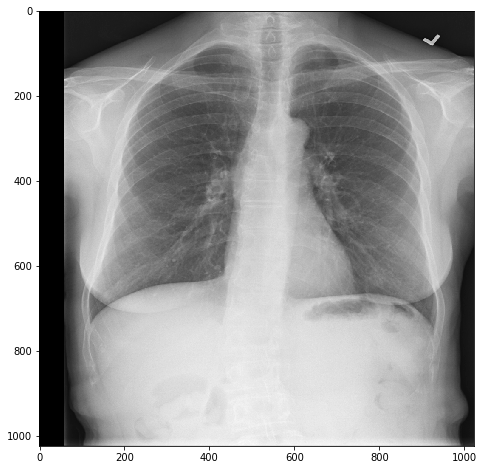

In [3]:

img = mpimg.imread(os.path.join(data_path, 'images','00000700_000.png'))
plt.figure(figsize=(8,8))
imgplot = plt.imshow(img, cmap='gray')

In [4]:

total_patient_number = 100
patient_id_original = [i for i in range(700, 800)]


name_list = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
             'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

labels_df = pd.read_csv(label_path)

patient_id = patient_id_original
print("len of patient id is", len(patient_id))

print("first ten patient ids are", patient_id[:10])

# training:valid:test 7:1:2
patient_id_train = patient_id[:int(total_patient_number * 0.7)]
patient_id_valid = patient_id[int(total_patient_number * 0.7):int(total_patient_number * 0.8)]
# get the rest of the patient_id as the test set
patient_id_test = patient_id[int(total_patient_number * 0.8):]

print("train, valid, test patients numbers are:", len(patient_id_train), len(patient_id_valid), len(patient_id_test))


def process_data(current_df, patient_ids):
    image_name_index = []
    image_labels = {}
    for individual_patient in tqdm.tqdm(patient_ids):
        for _, row in current_df[current_df['Patient ID'] == individual_patient].iterrows():
            processed_image_name = row['Image Index']
            image_name_index.append(processed_image_name)
            image_labels[processed_image_name] = np.zeros(14, dtype=np.uint8)
            for disease_index, ele in enumerate(name_list):
                if re.search(ele, row['Finding Labels'], re.IGNORECASE):
                    image_labels[processed_image_name][disease_index] = 1
                else:
                    # redundant code but just to make it more readable
                    image_labels[processed_image_name][disease_index] = 0
                # print("processed", row['Image Index'])
    return image_name_index, image_labels


train_data_index, train_labels = process_data(labels_df, patient_id_train)
valid_data_index, valid_labels = process_data(labels_df, patient_id_valid)
test_data_index, test_labels = process_data(labels_df, patient_id_test)

print("train, valid, test image number is:", len(train_data_index), len(valid_data_index), len(test_data_index))

# save the data
labels_all = {}
labels_all.update(train_labels)
labels_all.update(valid_labels)
labels_all.update(test_labels)

partition_dict = {'train': train_data_index, 'test': test_data_index, 'valid': valid_data_index}


  0%|          | 0/20 [00:00<?, ?it/s]

len of patient id is 100
first ten patient ids are [700, 701, 702, 703, 704, 705, 706, 707, 708, 709]
train, valid, test patients numbers are: 70 10 20


100%|██████████| 20/20 [00:00<00:00, 439.05it/s]


train, valid, test image number is: 257 25 99


# Defining the input pipeline
We want to define the input pipeline, so that all the transformation (such as resizing the images) can be done and will be put in a queue, which is ready to be served on GPUs

A few other settings:
- Learning rate set to 0.01
- Learning rate decays by 10 if the training loss does not decrease for 5 consecutive epochs
- Train/validation/test dataset: 7:1:2
- Using Adam optimizer and using standard parameters 
- Sigmoid function as the output since this is a multi-label problem and binary cross entropy as the loss function 
- Training for 100 epochs and select the one with smallest validation loss (In this tutorial we only train 2 epochs)

In [5]:
initial_lr = 0.001
resized_height = 224
resized_width = 224
num_channel = 3
num_classes = 14
epochs = 2
batch_size = 16


# generator for train and validation data
# use the Sequence class per issue https://github.com/keras-team/keras/issues/1638
class DataGenSequence(Sequence):
    def __init__(self, labels, image_file_index, current_state):
        self.batch_size = batch_size
        self.labels = labels
        self.img_file_index = image_file_index
        self.current_state = current_state
        self.len = len(self.img_file_index) // self.batch_size
        self.labels_df = pd.read_csv(label_path)
        self.entry_times = 0
        print("for DataGenSequence", current_state, "total rows are:", len(self.img_file_index), ", len is", self.len)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        start_time = timeit.default_timer()
        # make sure each batch size has the same amount of data
        current_batch = self.img_file_index[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, resized_height, resized_width, num_channel))
        y = np.empty((self.batch_size, num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(images_extracted_path, image_name)
            if not os.path.exists(path):
                print(path)
            x = cv2.imread(path)
            img = cv2.resize(cv2.imread(path), (resized_height, resized_width)).astype(np.float32)

            X[i, :, :, :] = img
            y[i, :] = labels[image_name]

            # only do random flipping in training status
            x_augmented = X

        # code you want to evaluate
        self.entry_times += 1
        elapsed = timeit.default_timer() - start_time
        return x_augmented, y



# Network Architecture (DenseNet)

Deep neural networks are notoriously hard to train well, especially when the neural networks get deeper. Inspired by the  [Stanford team](https://stanfordmlgroup.github.io/projects/chexnet/), we use the [DenseNet](https://arxiv.org/abs/1608.06993)-121 architecture with pre-trained weights from ImageNet as initialization parameters. This allows us to both pass the gradient more efficiently and train a deeper model. This architecture alleviates the vanishing-gradient problem and enables feature map reuse, which makes it possible to train very deep neural networks.

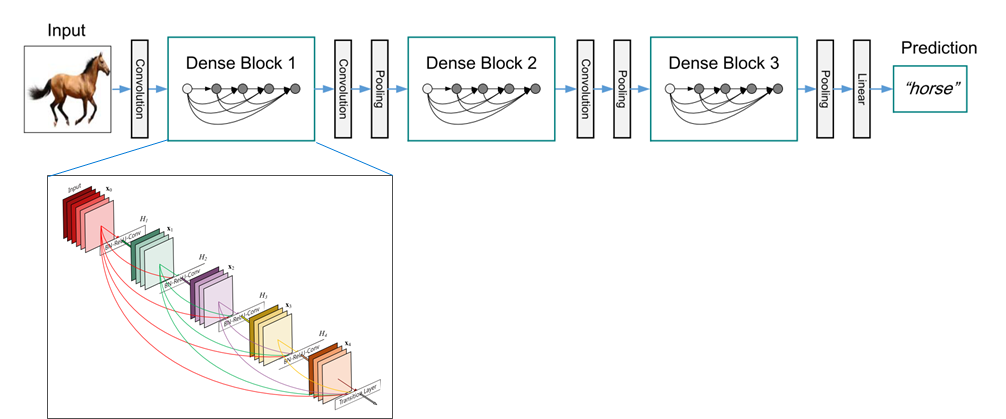

We will  use 100 patients for testing purpose, which is around 1% of the total dataset.

In [6]:
def build_model():
    """

    Returns: a model with specified weights

    """
    # define the model, use pre-trained weights for image_net
    base_model = DenseNetImageNet121(input_shape=(resized_height, resized_width, num_channel),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')

    x = base_model.output
    x = Dense(100, activation='relu')(x)
    predictions = Dense(14, activation='sigmoid', name="final_classifier")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


# loss function
def unweighted_binary_crossentropy(y_true, y_pred):
    """
    Args:
        y_true: true labels
        y_pred: predicted labels

    Returns: the sum of binary cross entropy loss across all the classes

    """
    return K.sum(K.binary_crossentropy(y_true, y_pred))

# Build and Run the model

In [7]:
model_gpu = build_model()
model_checkpoint = ModelCheckpoint(
    weights_file,
    monitor='val_loss', save_weights_only=False)

num_workers = 2

model_gpu.compile(optimizer=Adam(lr=initial_lr), loss=unweighted_binary_crossentropy)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.33333, patience=5, verbose=1, min_lr=1e-4)

tensor_board = TensorBoard(log_dir=tensorboard_dir)
callbacks = [model_checkpoint, reduce_lr_on_plateau, tensor_board]

labels = labels_all
partition = partition_dict

model_gpu.fit_generator(generator=DataGenSequence(labels, partition['train'], current_state='train'),
                              # steps_per_epoch=100,
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              workers=num_workers,
                              # validation_steps=100,
                              # max_queue_size=32,
                              shuffle=False,
                              validation_data=DataGenSequence(labels, partition['valid'], current_state='validation')
                              # validation_steps=1
                              )


Weights for the model were loaded successfully
for DataGenSequence train total rows are: 257 , len is 16
for DataGenSequence validation total rows are: 25 , len is 1
Epoch 1/2
16/16 [==============================] - 378s 24s/step - loss: 69.3956 - val_loss: 114.5161
Epoch 2/2
16/16 [==============================] - 355s 22s/step - loss: 48.7362 - val_loss: 362.8959


# Testing the actual model to get AUROC score


We use ROC (Receiver Operating Characteristic) and the AUC score (area under ROC curve) as the final metric
The reason is that medical dataset is usually highly unbalanced (for example Pneumonia only accounts for 1/77 of the data), and using ROC as the metrics can have a good balance between the True Positive Rate and the False Negative Rate.


## ROC Explanation
For each of the disease, it will be a `binary classification` task. For example, we will ask the model whether a particular chest x-ray image might have Cardiomegaly or not, Pneumonia or not, etc. Remember that for each of the disease, the model gives a **probability**, not a definitive **answer**. So we must set an threshold in order to make the final decision.

For example, we can choose the threshold as 0.9. In this case, we will only classify the patient has a particular disease (say Pneumonia) when the model is super confident about its prediction (more than 90%). Otherwise we will think the patient doesn't have that particular disease. This will probably cause a lot of false negatives (a patient actually has Pneumonia but our model fails to detect that).

On the other hand, we can choose the threshold as 0.1. In this case, we will be aggressively classify the patient for the given disease (again say Pneumonia), even when the model is not confident about its prediction (as long as it's larger than 10%).  This will probably cause a lot of false positives (a patient actually doesn't have Pneumonia but our model predicts it to have Pneumonia).

In practice, as you might have guessed, the decision boundary is a sticky spot. If we were choose 0.9 to increase the TPR (true positive rate), it will come at the expense of a larger FPR (false positive rate). The three parameters are tied to one another in a way that makes models hard to interpret and discuss.

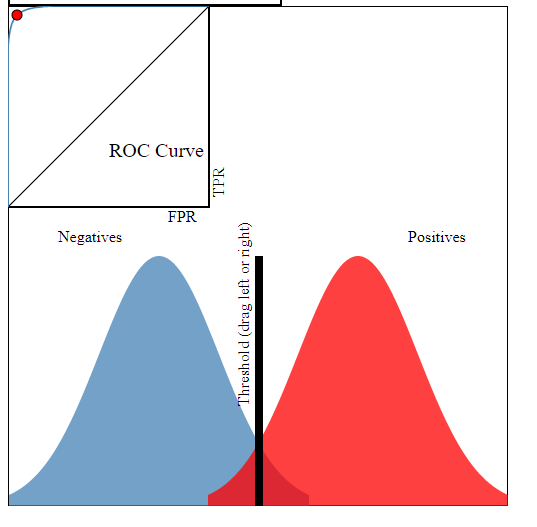
A good enough model that can distinguish positive and negative very well without tuning the threshold too much

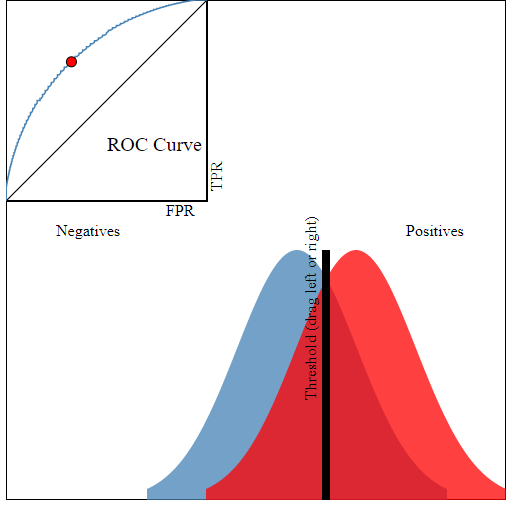
A bad  model that cannot distinguish positive and negative cases. Notice how the ROC curve changes

![image.png](https://www.dataschool.io/content/images/2014/11/roc12.PNG)
There's also a nice explanation article online: https://www.dataschool.io/roc-curves-and-auc-explained/. The interactive explanation is here: http://www.navan.name/roc/

As you can imagine, we don’t use accuracy here as accuracy usually don’t make sense.

Note the score will be very high since 1) the test set is very small for experimentation purpose; 2) the pre-trained model was trained using a random set of data which includes a lot of the testing data. The actual AUROC is around 0.845

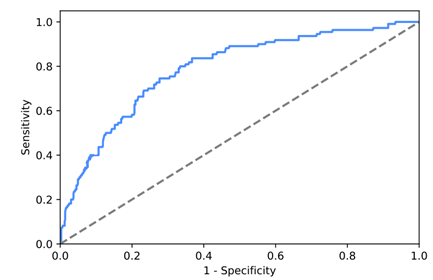

In [8]:
# load test data
X_test = np.empty((len(partition['test']), 224, 224, 3), dtype=np.float32)
y_test = np.empty((len(partition['test']) - len(partition['test']) % batch_size, 14), dtype=np.float32)

for i, npy in enumerate(partition['test']):
    if (i < len(y_test)):
        # round to batch_size
        y_test[i, :] = labels[npy]

print("len of result is", len(y_test))
y_pred_list = np.empty((len(partition['test']), 14), dtype=np.float32)

# individual models

print(pre_trained_model_path)
#    model = load_model(current_model_file)
model = keras.models.load_model(pre_trained_model_path)

print('evaluation for model', pre_trained_model_path)
# y_pred = model.predict(X_test)

y_pred = model.predict_generator(generator=DataGenSequence(labels, partition['test'], current_state='test'),
                                 workers=32, verbose=1, max_queue_size=1)
print("result shape", y_pred.shape)

# add one fake row of ones in both test and pred values to avoid:
# ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
y_test = np.insert(y_test, 0, np.ones((y_test.shape[1],)), 0)
y_pred = np.insert(y_pred, 0, np.ones((y_pred.shape[1],)), 0)

df = pd.DataFrame(columns=['Disease', 'Our AUC Score'])
for d in range(14):
    df.loc[d] = [name_list[d],
                 metrics.roc_auc_score(y_test[:, d], y_pred[:, d])]

print(df)

len of result is 96
/usr/local/share/xraytutorial/chexray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5


/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


evaluation for model /usr/local/share/xraytutorial/chexray_14_weights_712split_epoch_054_val_loss_191.2588.hdf5
for DataGenSequence test total rows are: 99 , len is 6
6/6 [==============================] - 56s 9s/step
result shape (96, 14)
               Disease  Our AUC Score
0          Atelectasis       0.946809
1         Cardiomegaly       0.994624
2             Effusion       0.968288
3         Infiltration       0.736786
4                 Mass       1.000000
5               Nodule       0.817460
6            Pneumonia       0.978947
7         Pneumothorax       1.000000
8        Consolidation       0.721987
9                Edema       1.000000
10           Emphysema       1.000000
11            Fibrosis       0.968421
12  Pleural_Thickening       0.926316
13              Hernia       1.000000


This is the actual AUROC score we get for the model running on actual test dataset:

| Disease | AUC Score | Disease | AUC Score |
| --- | --- | --- | --- |
| Atelectasis | 0.828543 | Pneumothorax | 0.881838 |
| Cardiomegaly | 0.891449 | Consolidation | 0.721818 |
| Effusion | 0.817697 | Edema | 0.868002 |
| Infiltration | 0.907302 | Emphysema | 0.787202 |
| Mass | 0.895815 | Fibrosis | 0.826822 |
| Nodule | 0.907841 | Pleural Thickening | 0.793416 |
| Pneumonia | 0.817601 | Hernia | 0.889089 |
